# Setup

In [2]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
import datetime as dt

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
ds_CD = xr.open_dataset('../data/CD/CD.nc')

In [3]:
def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def find_extended_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

# Find Boxes

In [ ]:
# Create time slice from dates
year = '2004'
start_time = year +'-01-01'
end_time = year+'-12-31'

fig = plt.figure(figsize=(15, 18))

for ii, box in enumerate(bboxes): 

    # Create slice variables subset domain
    lat_slice = slice(box[2], box[3])
    lon_slice = slice(box[0], box[1])

    # Get data, selecting time, level, lat/lon slice
    data = sla.sel(time=time_slice,latitude=lat_slice,
                         longitude=lon_slice)

    cmin = -0.2
    cmax = 0.2
    no_levels = 16
    
    
    levels = np.linspace(cmin, cmax, no_levels)
    
    if (ii == 1) | (ii == 4)| (ii == 5):
        # Compute weights and take weighted average over latitude dimension
        weights = np.cos(np.deg2rad(data.latitude.values))
        avg_data = (data * weights[:, None]).sum(dim='latitude') / np.sum(weights)

        #smoothed data
        sm_data = xr.DataArray(gaussian_filter(avg_data, sigma=1.5),coords = [avg_data.time,avg_data.longitude])

        # Get times and make array of datetime objects
        vtimes = data.time.values.astype('datetime64[ms]').astype('O')

        # Specify longitude values for chosen domain
        lons = data.longitude.values
        lats = data.latitude.values

        ax = fig.add_subplot(2,3,ii+1)

        # Plot of chosen variable averaged over latitude
        cf = ax.contourf(lons, vtimes,sm_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
        ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
        plt.xlabel('Longitude')
        plt.title('Box ' + str(ii+1))
        cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
    else:
        # Compute weights and take weighted average over latitude dimension
        avg_data = data.mean(dim='longitude')

        #smoothed data
        sm_data = xr.DataArray(gaussian_filter(avg_data, sigma=1.5),coords = [avg_data.time,avg_data.latitude])

        # Get times and make array of datetime objects
        vtimes = data.time.values.astype('datetime64[ms]').astype('O')

        # Specify longitude values for chosen domain
        lons = data.longitude.values
        lats = data.latitude.values

        ax = fig.add_subplot(2,3,ii+1)

        # Plot of chosen variable averaged over latitude
        cf = ax.contourf(lats, vtimes, sm_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
        ax.set_yticklabels(['01', '02','03', '04', '05','06','07','08','09','10','11','12'])
        plt.xlabel('Latitude')
        plt.title('Box ' + str(ii+1))
        cf.set_clim(cmin, cmax)
 
cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04,ticks=levels, label='Sea Level Anomaly ($m$)')
# cbar.set_label('Sea Level Anomaly ($m$)')




# Group Into IOD Phases

In [100]:
# # load DMI data
# ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
# ds_DMI

# # lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
# posIODyears = list(np.array(ds_DMI.pos_IOD_years[ds_DMI.pos_IOD_years >= 1994])) #[1994,1997,2006,2012,2015]
# # posIODwENSOyears = ['1997']
# negIODyears = list(np.array(ds_DMI.neg_IOD_years[ds_DMI.neg_IOD_years >= 1994])) #[1996,1998,2001,2010,2014,2016]
# # negIODwENSOyears = ['1998']
# neuIODyears = list(np.array(ds_DMI.neu_IOD_years[ds_DMI.neu_IOD_years >= 1994])) # [1995,1999,2000,2002,2003,2004,2005,2007,2008,2009,2011,2012,2013]

# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = list(np.array(ds_DMI.pos_IOD_years)) #[1994,1997,2006,2012,2015]
# posIODwENSOyears = ['1997']
negIODyears = list(np.array(ds_DMI.neg_IOD_years)) #[1996,1998,2001,2010,2014,2016]
# negIODwENSOyears = ['1998']
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) # [1995,1999,2000,2002,2003,2004,2005,2007,2008,2009,2011,2012,2013]

# posIODyears, negIODyears, neuIODyears

In [101]:
# binning for one variable ------------------------------------------------------------#
def latlonbin_month(invar,lat,lon,month,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
            month = month
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((12,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((12,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((12,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan
    
    #extract the data for each group
    for name,group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        
        #group a second time by month
        mon_grouped = group.groupby(['month'])
        
        for mm,mon_group in mon_grouped:

            invar_BINNED[mm-1,i[0],j[0]] = mon_group.invar

            invar_binned_ave[mm-1,i[0],j[0]] = np.nanmean(mon_group.invar)   

            invar_bincounts[mm-1,i[0],j[0]] = len(mon_group.invar[np.isfinite(mon_group.invar)]) 


    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

In [102]:
# average over the positive IOD years -------------------------------------------# 
mon_data = []
mon_lat = []
mon_lon = []
mon_time = []
mon_month = []

for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.extend(np.array(ds_CD.TCD_AWG.sel(time=time_slice)))
    mon_lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    mon_lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    mon_time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    t = ds_CD.time.sel(time=time_slice)
    mon_month.extend(np.array(t.time.dt.month))


bounds = [35,120,-20,30]
    
# bin for each month
posIOD_TCD,_,latbins,lonbins = latlonbin_month(mon_data,mon_lat,mon_lon,mon_month,bounds,1)

# average over the negative IOD years -------------------------------------------# 
mon_data = []
mon_lat = []
mon_lon = []
mon_time = []
mon_month = []

for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.extend(np.array(ds_CD.TCD_AWG.sel(time=time_slice)))
    mon_lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    mon_lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    mon_time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    t = ds_CD.time.sel(time=time_slice)
    mon_month.extend(np.array(t.time.dt.month))


bounds = [35,120,-20,30]
    
# bin for each month
negIOD_TCD,_,latbins,lonbins = latlonbin_month(mon_data,mon_lat,mon_lon,mon_month,bounds,1)

# average over the neutral IOD years -------------------------------------------# 
mon_data = []
mon_lat = []
mon_lon = []
mon_time = []
mon_month = []

for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.extend(np.array(ds_CD.TCD_AWG.sel(time=time_slice)))
    mon_lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    mon_lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    mon_time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    t = ds_CD.time.sel(time=time_slice)
    mon_month.extend(np.array(t.time.dt.month))


bounds = [35,120,-20,30]
    
# bin for each month
neuIOD_TCD,_,latbins,lonbins = latlonbin_month(mon_data,mon_lat,mon_lon,mon_month,bounds,1)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice


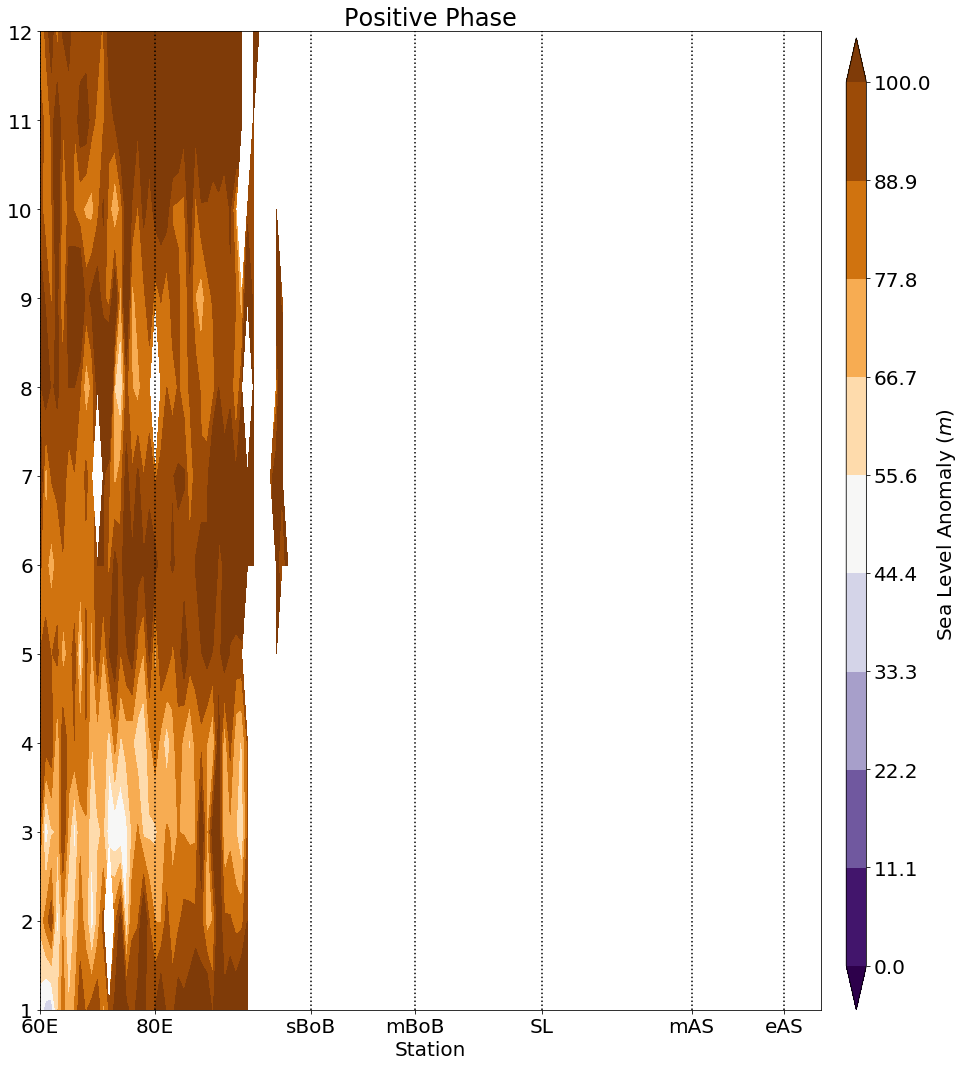

In [103]:
plt.rcParams.update({'font.size': 20})

cmin = 0
cmax = 100


fig = plt.figure(figsize=(14, 18))

# Get times and make array of datetime objects
vtimes = np.arange(1,13)

data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
for jj in range(sta_loninds.shape[0]):
    data[:,jj] = neuIOD_TCD[:,sta_latinds[jj],sta_loninds[jj]]

# colorbar limits
levels = np.linspace(cmin, cmax, 10)

# Specify longitude values for chosen domain
sta = np.arange(len(sta_loninds))

ax = fig.add_subplot(1,1,1)

# Plot of chosen variable averaged over latitude and slightly smoothed
cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
for loc in loc_list:
    plt.axvline(x=loc,color = 'k',linestyle = ':')

plt.xlabel('Station')
if ii == 0:
    plt.ylabel('Month')

plt.title('Positive Phase')
# ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
ax.set_xticks(loc_list)
ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
ax.set_yticks(list(np.arange(1,13)))
cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')
# plt.savefig('../figures/' + titles_save[ii] +'-SLA-along-coast.png', dpi=300, bbox_inches='tight')





In [84]:
# # take the mean for each month of all the years
# posIOD_TCD_AWG = posIOD_TCD_AWG.groupby('time.month').mean(dim='time')
# #start in march instead of 01
# posIOD_TCD_AWG =posIOD_TCD_AWG.roll(month=-5,roll_coords = False)

# posIOD_TCD_AWG.shape

# # average over the negative IOD years -------------------------------------------# 
# mon_data = []
# # for ii,year in enumerate(list(np.array(ds_DMI.neg_IOD_years))):
# for ii,year in enumerate(negIODyears):
#     start_time = str(year) + '-06-01'
#     end_time = str(year+1) + '-05-31'
#     time_slice = slice(start_time, end_time)
#     mon_data.append(mon_sla_dtrnd.sel(month_time=time_slice))
    
# negIOD_mon_sla_dtrnd = xr.concat(mon_data, dim='month_time')
# negIOD_mon_sla_dtrnd = negIOD_mon_sla_dtrnd.groupby('month_time.month').mean(dim='month_time')
# negIOD_mon_sla_dtrnd =negIOD_mon_sla_dtrnd.roll(month=-5,roll_coords = False)

# # average over the neutral IOD years -------------------------------------------# 
# mon_data = []
# # for ii,year in enumerate(list(np.array(ds_DMI.neu_IOD_years))):
# for ii,year in enumerate(neuIODyears):
#     start_time = str(year) + '-06-01'
#     end_time = str(year+1) + '-05-31'
#     time_slice = slice(start_time, end_time)
#     mon_data.append(mon_sla_dtrnd.sel(month_time=time_slice))

# neuIOD_mon_sla_dtrnd = xr.concat(mon_data, dim='month_time')
# neuIOD_mon_sla_dtrnd = neuIOD_mon_sla_dtrnd.groupby('month_time.month').mean(dim='month_time')
# neuIOD_mon_sla_dtrnd = neuIOD_mon_sla_dtrnd.roll(month=-5,roll_coords = False)

<xarray.DataArray 'time' (time: 12)>
array(['1994-06-01T00:00:00.000000000', '1994-07-01T00:00:00.000000000',
       '1994-08-01T00:00:00.000000000', '1994-09-01T00:00:00.000000000',
       '1994-10-01T00:00:00.000000000', '1994-11-01T00:00:00.000000000',
       '1994-12-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1995-02-01T00:00:00.000000000', '1995-03-01T00:00:00.000000000',
       '1995-04-01T00:00:00.000000000', '1995-05-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1994-06-01 1994-07-01 ... 1995-05-01

# Group Anomalies Into IOD Phases

In [182]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = list(np.array(ds_DMI.pos_IOD_years[ds_DMI.pos_IOD_years >= 1994])) #[1994,1997,2006,2012,2015]
# posIODwENSOyears = ['1997']
negIODyears = list(np.array(ds_DMI.neg_IOD_years[ds_DMI.neg_IOD_years >= 1994])) #[1996,1998,2001,2010,2014,2016]
# negIODwENSOyears = ['1998']
neuIODyears = list(np.array(ds_DMI.neu_IOD_years[ds_DMI.neu_IOD_years >= 1994])) # [1995,1999,2000,2002,2003,2004,2005,2007,2008,2009,2011,2012,2013]

In [183]:
# average over the positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
# for ii,year in enumerate(list(np.array(ds_DMI.pos_IOD_years))):
for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

# add all the data together
posIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
# take the mean for each month of all the years
posIOD_mon_sla_mon_anom_dtrnd = posIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
#start in march instead of 01
posIOD_mon_sla_mon_anom_dtrnd =posIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.neg_IOD_years))):
for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))
    
negIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
negIOD_mon_sla_mon_anom_dtrnd = negIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
negIOD_mon_sla_mon_anom_dtrnd =negIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

# average over the neutral IOD years -------------------------------------------# 
daily_data = []
mon_data = []
# for ii,year in enumerate(list(np.array(ds_DMI.neu_IOD_years))):
for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(month_time=time_slice))

neuIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='month_time')
neuIOD_mon_sla_mon_anom_dtrnd = neuIOD_mon_sla_mon_anom_dtrnd.groupby('month_time.month').mean(dim='month_time')
neuIOD_mon_sla_mon_anom_dtrnd = neuIOD_mon_sla_mon_anom_dtrnd.roll(month=-5,roll_coords = False)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [184]:
# create list of integer years
IODphases = list([posIOD_mon_sla_dtrnd,negIOD_mon_sla_dtrnd,neuIOD_mon_sla_dtrnd])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/IOD-years-total-SLA-along-coast.png', dpi=300, bbox_inches='tight')




NameError: name 'posIOD_mon_sla_dtrnd' is not defined

# Hovmueller Diagrams for 0.25 Degree

## Interannual Data

## Seasonal

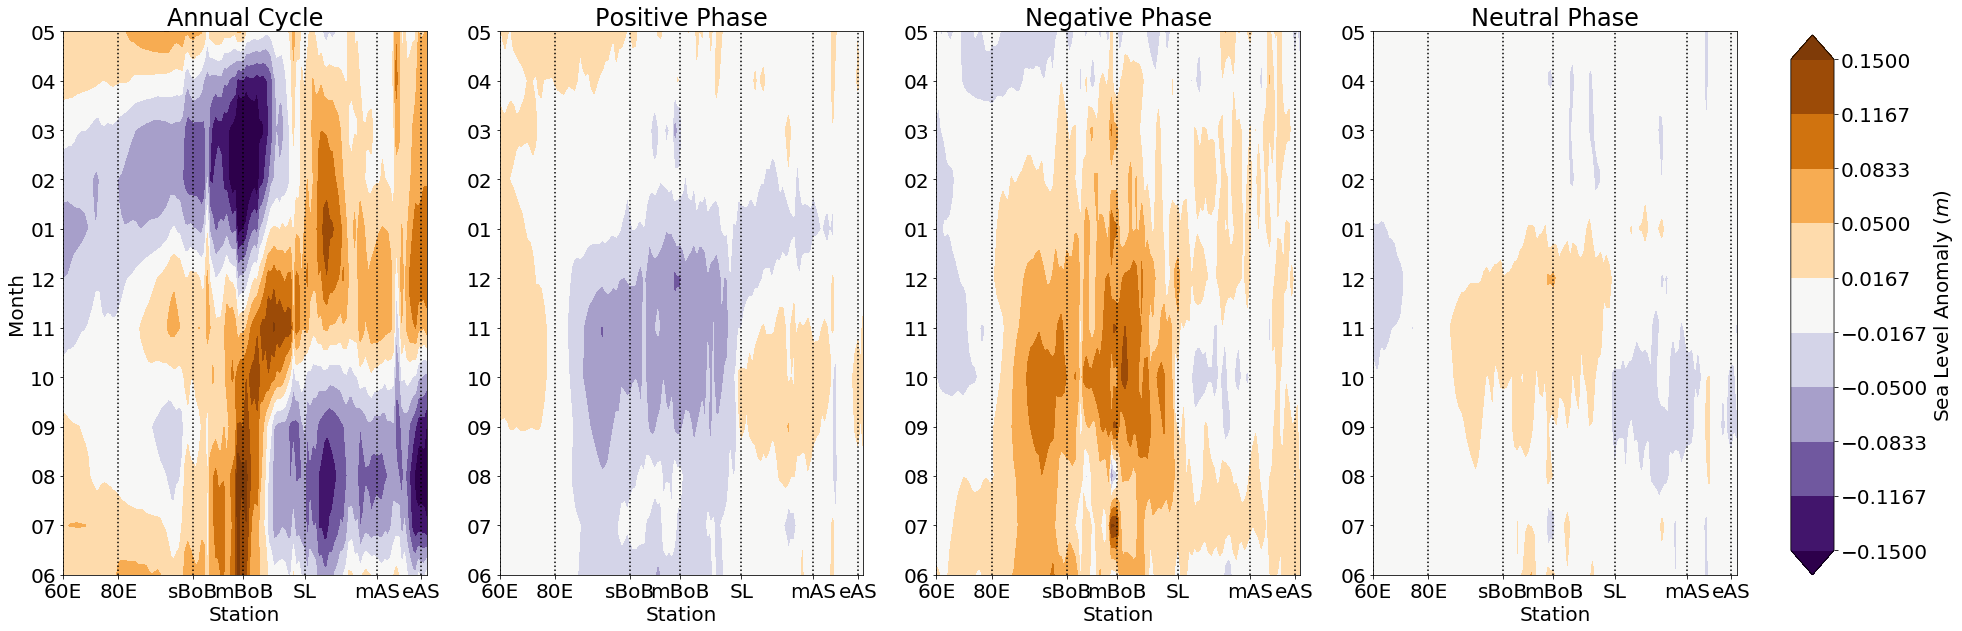

In [185]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,4,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/seasonal-and-IOD-years-SLA-along-coast.png', dpi=300, bbox_inches='tight')



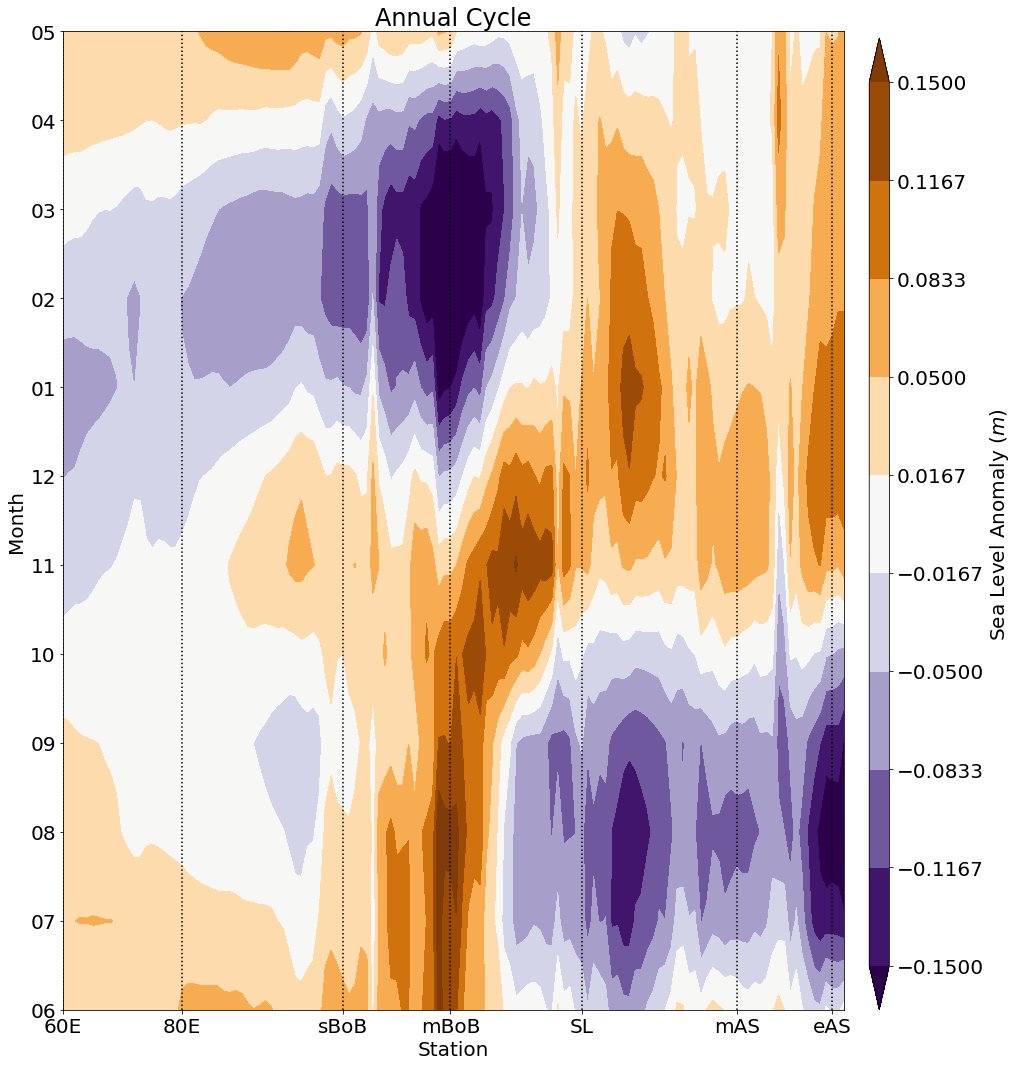

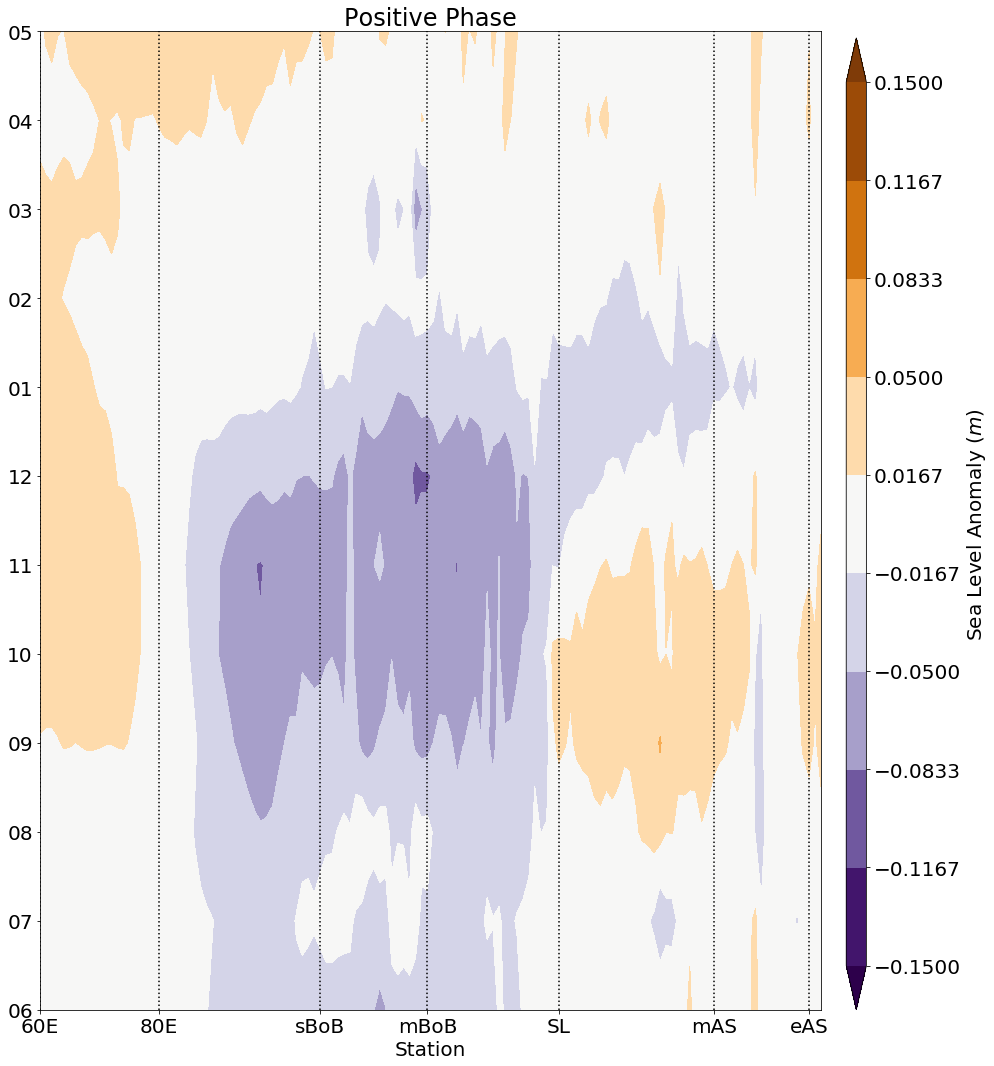

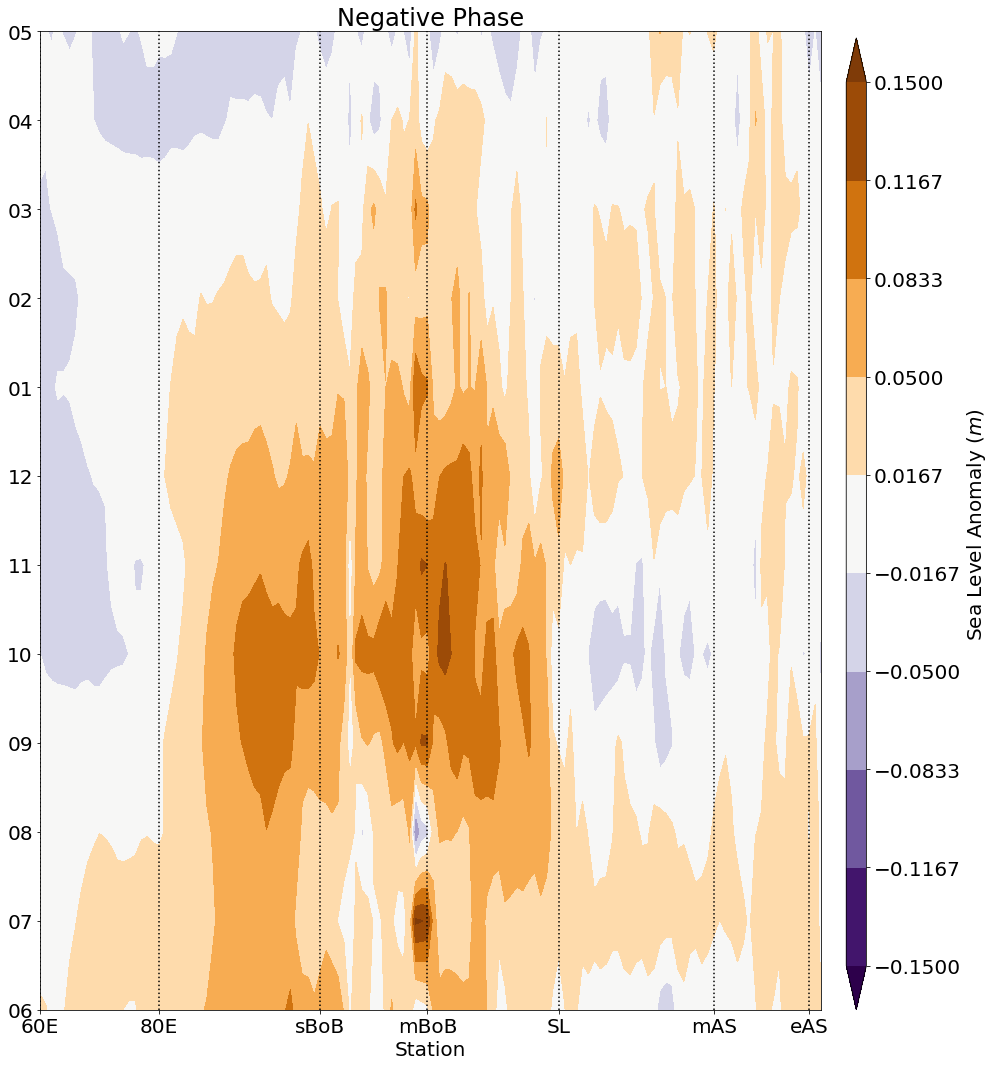

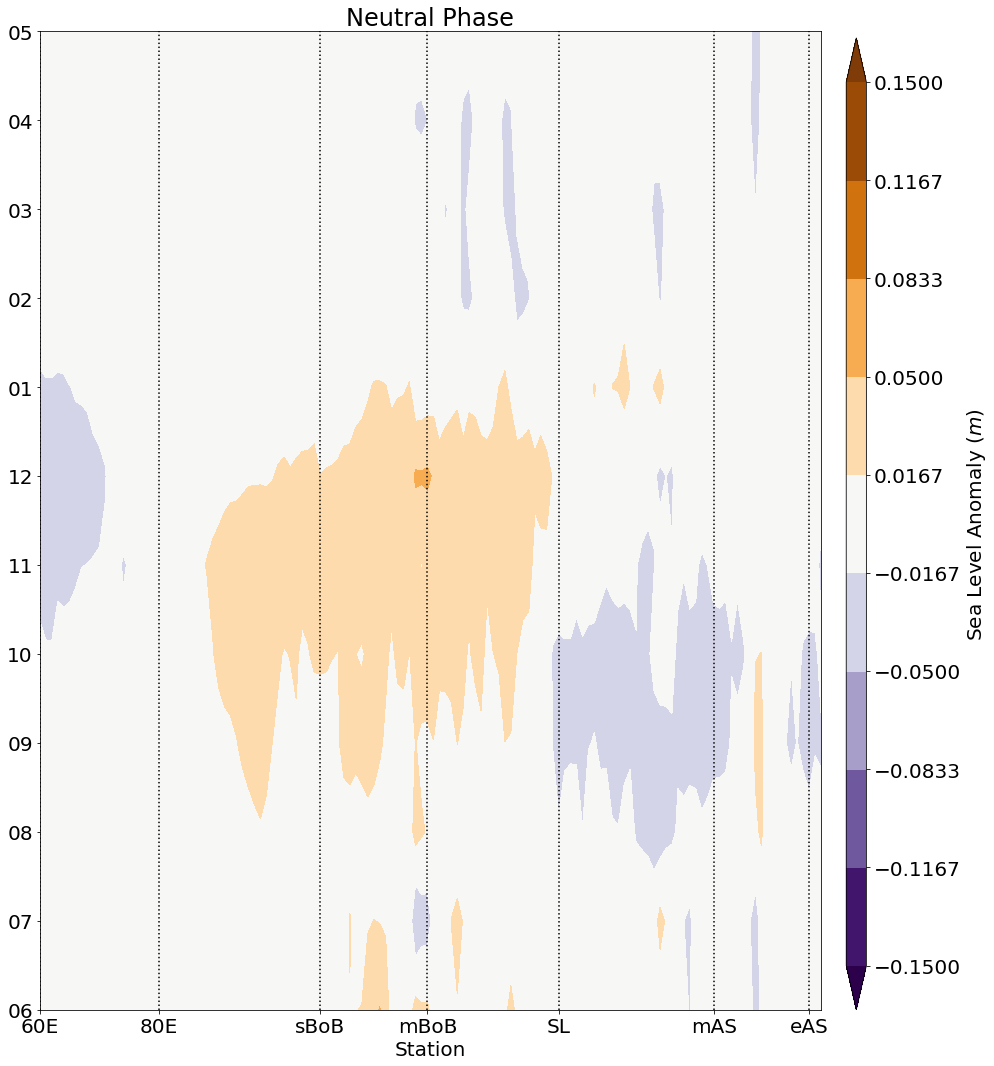

In [186]:
# singular plots 
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
titles_save = ['annual-cycle','positive-phase','negative-phase', 'neutral-phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.15
cmax = 0.15

for ii,phase in enumerate(IODphases):
    
    fig = plt.figure(figsize=(14, 18))
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,1,1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label('Sea Level Anomaly ($m$)')
    plt.savefig('../figures/' + titles_save[ii] +'-SLA-along-coast.png', dpi=300, bbox_inches='tight')




# Seasonal Cycle

In [187]:
ds_SLA.sla_seas_clim_dtrnd_1deg

<xarray.DataArray 'sla_seas_clim_dtrnd_1deg' (season: 4, latitude_1deg: 50, longitude_1deg: 85)>
array([[[ 0.022153,  0.017086, ..., -0.002893,  0.001697],
        [ 0.020289,  0.014525, ..., -0.002446,  0.000716],
        ...,
        [ 0.136102,  0.134739, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-0.018691, -0.012775, ..., -0.015905, -0.015917],
        [-0.018258, -0.012412, ..., -0.010177, -0.013057],
        ...,
        [-0.160679, -0.15934 , ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[ 0.018199,  0.022192, ...,  0.076383,  0.065947],
        [ 0.020624,  0.025659, ...,  0.059294,  0.058917],
        ...,
        [ 0.040867,  0.041357, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-0.022493, -0.027376, ..., -0.059363, -0.053295],
        [-0.023534, -0.028852, ..., -0.047961, -0.047942],
        ...,
        [-0.017167,

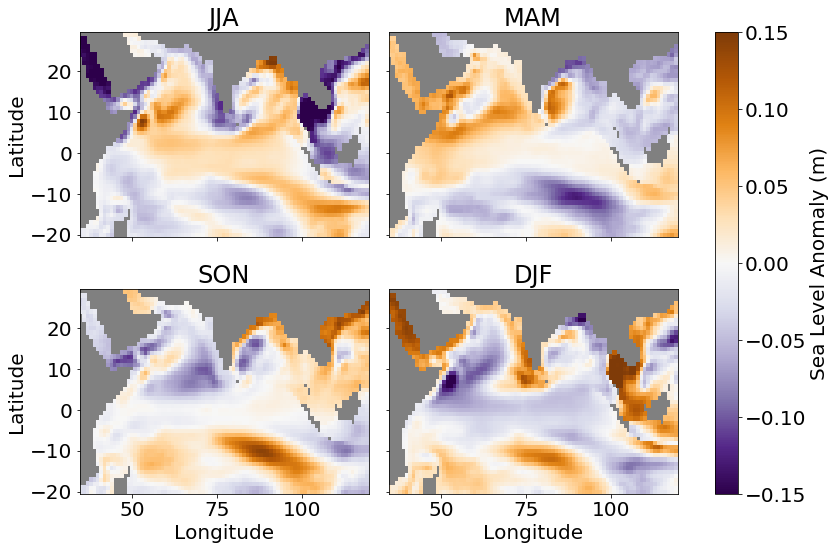

In [130]:
season = ['JJA','MAM','SON','DJF']

rolled_seas_cycle = ds_SLA.sla_seas_clim_dtrnd_1deg.roll(season=-1,roll_coords = False)
p = rolled_seas_cycle.plot.pcolormesh(x="longitude_1deg", y="latitude_1deg", col="season", col_wrap=2,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 8),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(season[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')
plt.savefig('../figures/seasonal-cycle-SLA.png', dpi=300, bbox_inches='tight')

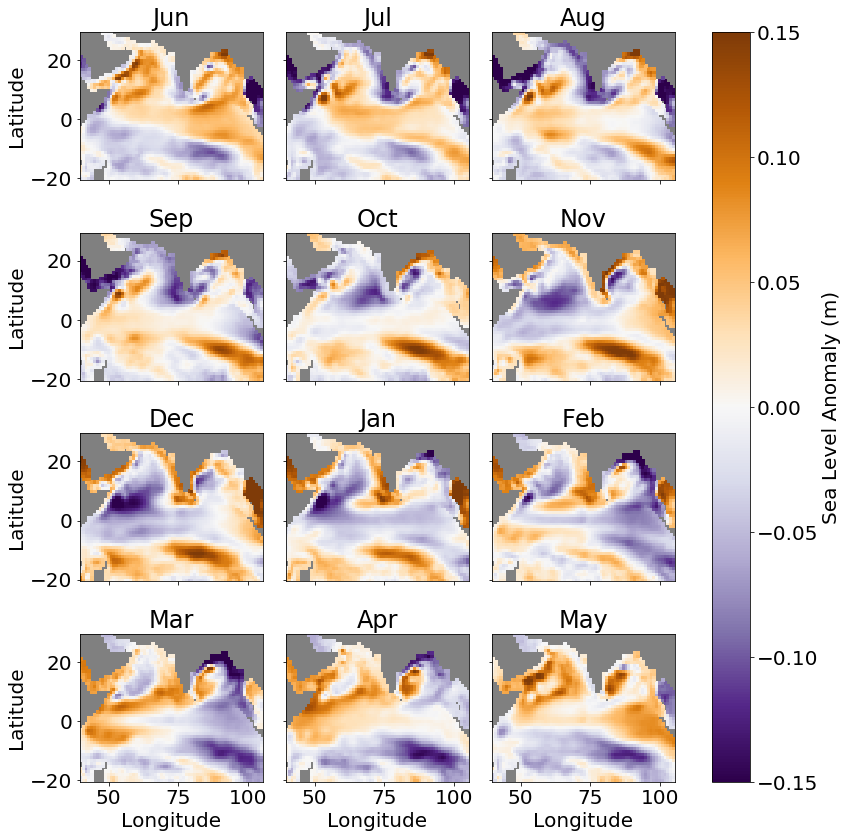

In [132]:
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

rolled_ann_cycle = ds_SLA.sla_mon_clim_dtrnd_1deg.roll(month=-5,roll_coords = False)
p = rolled_ann_cyc.plot.pcolormesh(x="longitude_1deg", y="latitude_1deg", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')
plt.savefig('../figures/annual-cycle-SLA.png', dpi=300, bbox_inches='tight')

In [ ]:
# posIOD
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

p = posIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

In [ ]:
# negIOD
months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May',]

p = negIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

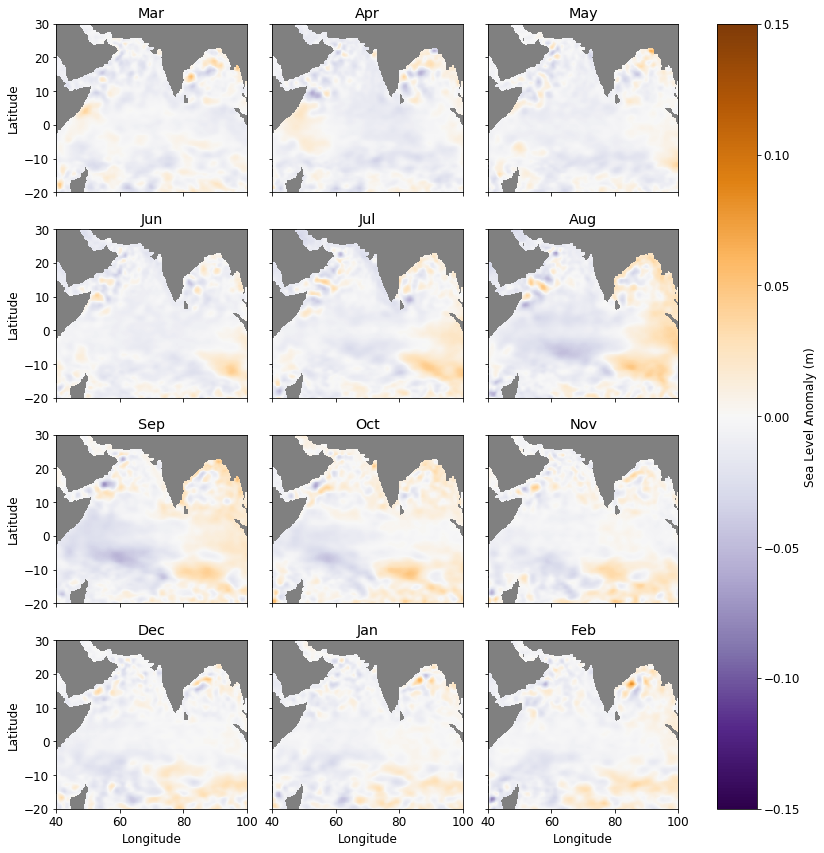

In [68]:
# neuIOD
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = neuIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

# Differences between annual cycle and positive IOD years

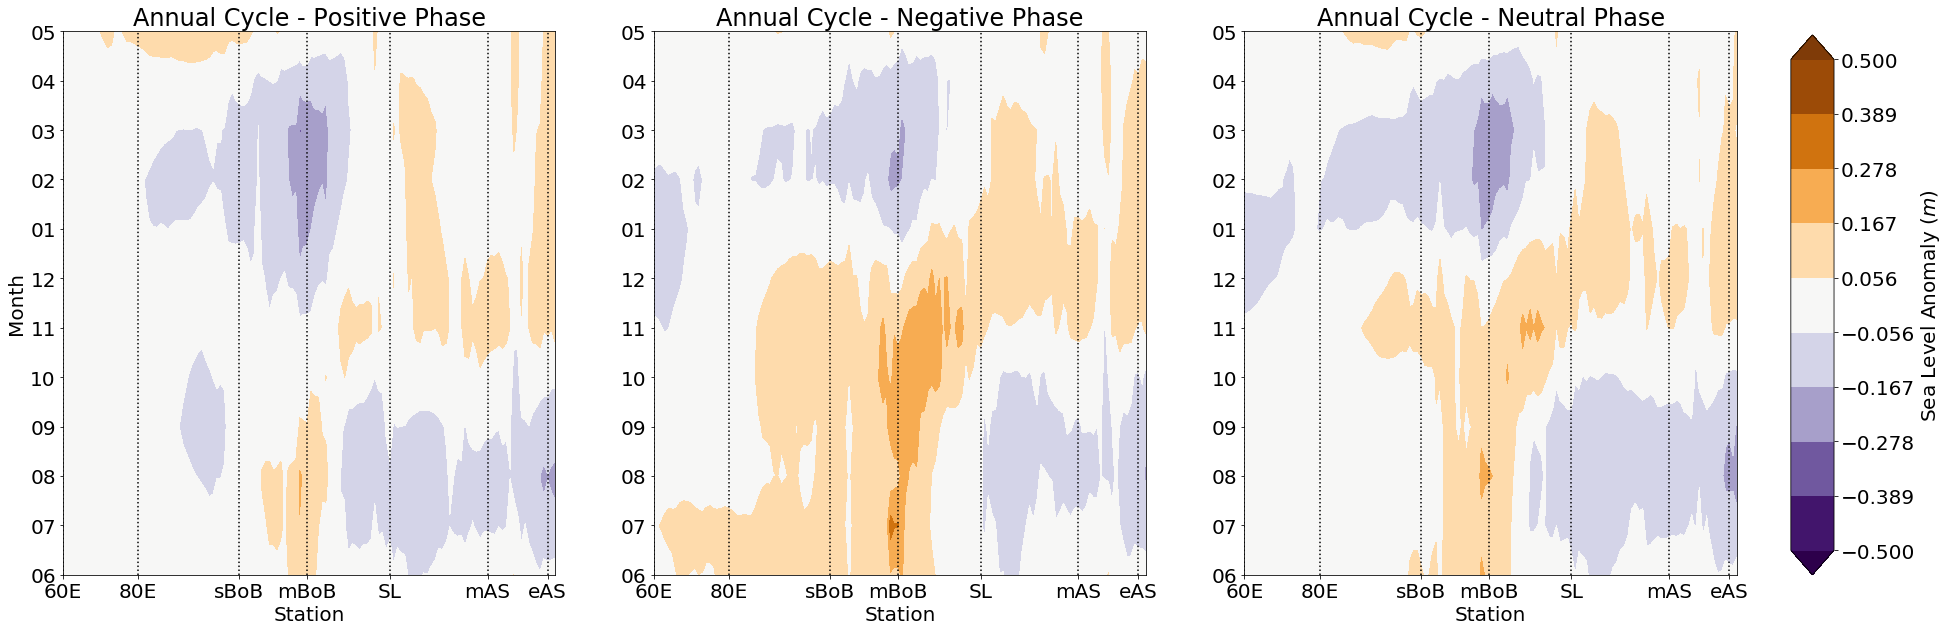

In [162]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-5,roll_coords = False)
IODphases = list([posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 20})

cmin = -0.5
cmax = 0.5

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    seasdata = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]
        seasdata[:,jj] = rolled_ann_cyc[:,sta_latinds[jj],sta_loninds[jj]]

    var = (seasdata + data)
    
    
    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,var,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title('Annual Cycle - ' + titles[ii])
    ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')

plt.savefig('../figures/seasonal-and-IOD-years-differences-SLA-along-coast.png', dpi=300, bbox_inches='tight')




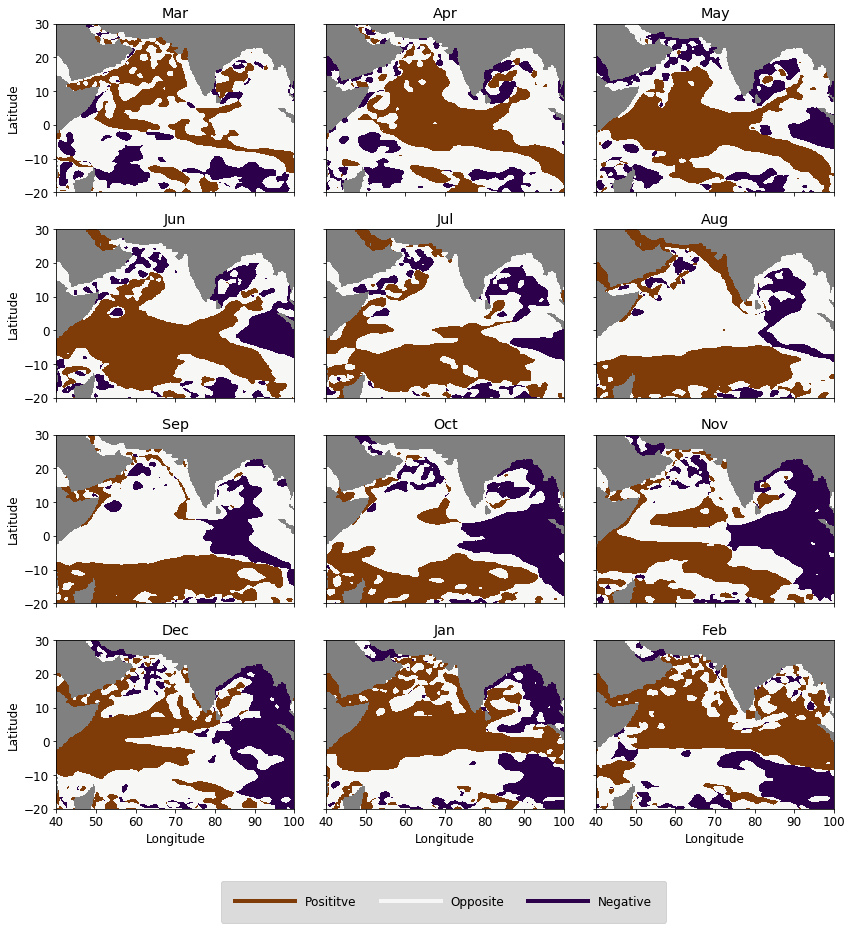

In [69]:
# posIOD

seas
iod = 
var = np.sign(posIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')

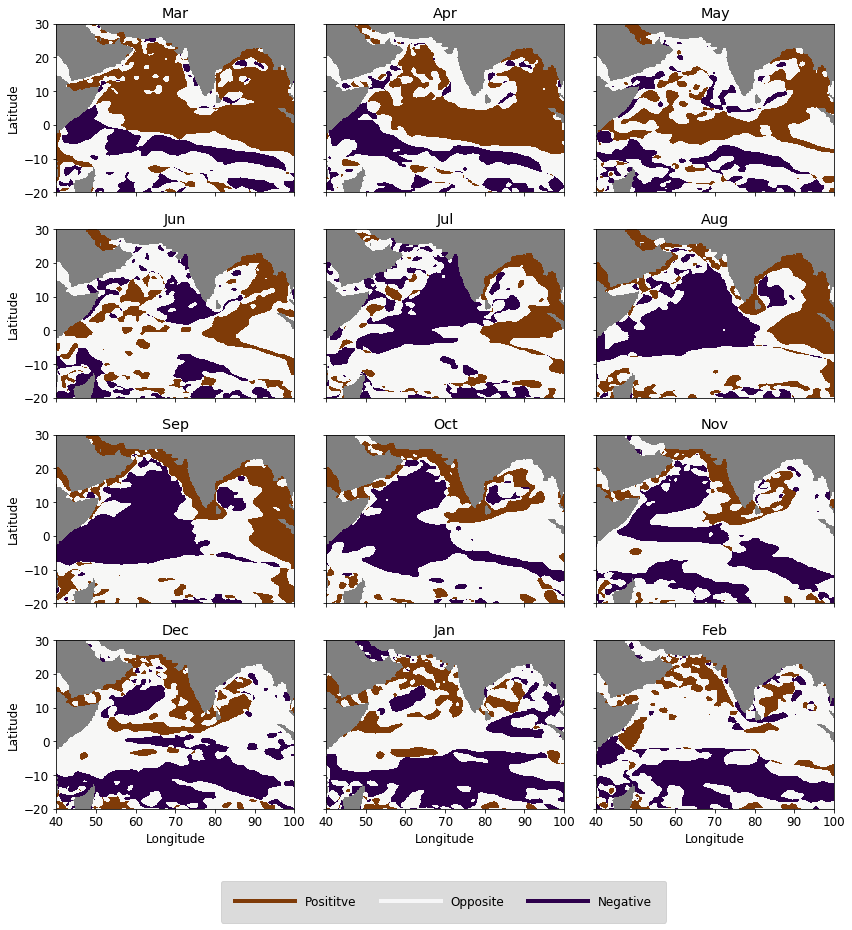

In [70]:
# negIOD

var = np.sign(negIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')